In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


Using TensorFlow backend.


In [2]:
def load_document(filename): 
    file=open(filename,'r')
    doc=file.read()
    file.close()
    return doc

In [3]:
def convert_doc_to_dictionary(doc):
    descriptions=dict()
    for line in doc.split('\n'):
        tokens=line.split()
        if (tokens!=[]):
            image_id,image_desc=tokens[0],tokens[1:]
            image_id=image_id.split('.')[0]
            image_desc = ' '.join(image_desc)
            if image_id not in descriptions:
                descriptions[image_id] =list()
            (descriptions[image_id]).append(image_desc)
    return descriptions

In [4]:
filename="/Users/samriddhakc/Desktop/DerbyHacks2019/ImageCaptioning/Image-Captioning-master/Flickr8k_text/Flickr8k.token.txt"
#filename="/Users/samriddhakc/Desktop/DerbyHacks2019/ImageCaptioning/Image-Captioning-master/Flickr8k_text/Flickr_8k.trainImages.txt"
#filename="/Users/samriddhakc/Desktop/DerbyHacks2019/ImageCaptioning/Image-Captioning-master/Flickr8k_text/Flickr_8k.trainImages.txt"
doc=load_document(filename)
descriptions=convert_doc_to_dictionary(doc)
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [5]:
# prepare translation table for removing punctuation
def clean_descriptions_dict(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

In [6]:
clean_descriptions_dict(descriptions)
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [7]:
def get_vocabulary(descriptions):
    vocabulary = set()
    for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
    return vocabulary
vocabulary=get_vocabulary(descriptions)
print("The total voacbulary for this dataset is", len(vocabulary))

The total voacbulary for this dataset is 8763


In [8]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [9]:
def load_set(filename):
    doc=load_document(filename)
    dataset=list()
    for line in doc.split('\n'):
        image_id_getter=line.split('.')[0]
        dataset.append(image_id_getter)
    return set(dataset)

filename="/Users/samriddhakc/Desktop/DerbyHacks2019/ImageCaptioning/Image-Captioning-master/Flickr8k_text/Flickr_8k.trainImages.txt"
train=load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [10]:
# Create a list of all image names in the directory
images="/Users/samriddhakc/Desktop/DerbyHacks2019/ImageCaptioning/Image-Captioning-master/Flicker8k_Dataset/"
img = glob.glob(images + '*.jpg')

In [12]:
train_img = []
for i in img:
    if (i[len(images):].split('.')[0] in train): 
        train_img.append(i)

In [13]:
test_file="/Users/samriddhakc/Desktop/DerbyHacks2019/ImageCaptioning/Image-Captioning-master/Flickr8k_text/Flickr_8k.testImages.txt"
test_images = set(open(test_file, 'r').read().strip().split('\n'))
test_img=[]
for i in img:
    if (i[len(images):] in test_images): 
        test_img.append(i)

In [14]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_document(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))


Descriptions: train=6000


In [15]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [16]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

W0906 12:13:45.728703 140736272098176 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 12:13:45.748293 140736272098176 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 12:13:45.752194 140736272098176 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 12:13:45.785661 140736272098176 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0906 12:13:45.786947 1407362720

In [17]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [18]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [19]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 1665.1010947227478


In [24]:
import pickle

In [25]:
# Save the bottleneck train features to disk
with open("./encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [26]:
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 6107.532357931137


In [28]:
with open("./encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [31]:
#import the feature vector for the transfer learning 
train_features = load(open("./encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))
test_features = load(open("./encoded_test_images.pkl", "rb"))
print('Photos: train=%d' % len(test_features))

Photos: train=6000
Photos: train=1000


In [34]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [51]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w,0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [52]:
ixtoword={}
wordtoix={}
ix=1
for w in vocab: 
    wordtoix[w]=ix
    ixtoword[ix]=w
    ix=ix+1

In [68]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [58]:
def to_lines(descriptions): 
    desc_all=list()
    for key in descriptions.keys():
        [desc_all.append(d) for d in descriptions[key]]
        
    return desc_all
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)


Description Length: 34


In [76]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [78]:
#Load Glove vectors
glove_dir = '../../storage/glove'
embeddings_index = {} # empty dictionary
f = open("./glove.6B.200d.txt", encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [69]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [79]:
embedding_matrix.shape

(1652, 200)

In [71]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

W0907 13:45:04.498471 140736272098176 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0907 13:45:05.910698 140736272098176 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [72]:

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [73]:
model.layers[2]
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')

W0907 13:46:22.903956 140736272098176 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [74]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [81]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 687s 344ms/step - loss: 3.4199
Epoch 1/1
2000/2000 [==============================] - 695s 348ms/step - loss: 3.2009
Epoch 1/1
2000/2000 [==============================] - 713s 357ms/step - loss: 3.0657
Epoch 1/1
2000/2000 [==============================] - 702s 351ms/step - loss: 2.9713
Epoch 1/1
2000/2000 [==============================] - 835s 417ms/step - loss: 2.8971
Epoch 1/1
2000/2000 [==============================] - 681s 340ms/step - loss: 2.8370
Epoch 1/1
2000/2000 [==============================] - 687s 344ms/step - loss: 2.7894
Epoch 1/1
2000/2000 [==============================] - 705s 353ms/step - loss: 2.7506
Epoch 1/1
2000/2000 [==============================] - 661s 331ms/step - loss: 2.7141
Epoch 1/1
2000/2000 [==============================] - 758s 379ms/step - loss: 2.6830


In [83]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 771s 385ms/step - loss: 2.6354
Epoch 1/1
2000/2000 [==============================] - 974s 487ms/step - loss: 2.6132
Epoch 1/1
2000/2000 [==============================] - 717s 359ms/step - loss: 2.5961
Epoch 1/1
2000/2000 [==============================] - 727s 364ms/step - loss: 2.5793
Epoch 1/1
2000/2000 [==============================] - 748s 374ms/step - loss: 2.5632
Epoch 1/1
2000/2000 [==============================] - 709s 354ms/step - loss: 2.5470
Epoch 1/1
2000/2000 [==============================] - 666s 333ms/step - loss: 2.5325
Epoch 1/1
2000/2000 [==============================] - 667s 334ms/step - loss: 2.5206
Epoch 1/1
2000/2000 [==============================] - 669s 334ms/step - loss: 2.5122
Epoch 1/1
2000/2000 [==============================] - 876s 438ms/step - loss: 2.5035


In [96]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [97]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 607s 607ms/step - loss: 2.4600
Epoch 1/1
1000/1000 [==============================] - 597s 597ms/step - loss: 2.4398
Epoch 1/1
1000/1000 [==============================] - 567s 567ms/step - loss: 2.4269
Epoch 1/1
1000/1000 [==============================] - 563s 563ms/step - loss: 2.4211
Epoch 1/1
1000/1000 [==============================] - 587s 587ms/step - loss: 2.4074
Epoch 1/1
1000/1000 [==============================] - 622s 622ms/step - loss: 2.3996
Epoch 1/1
1000/1000 [==============================] - 600s 600ms/step - loss: 2.3929
Epoch 1/1
1000/1000 [==============================] - 536s 536ms/step - loss: 2.3853
Epoch 1/1
1000/1000 [==============================] - 617s 617ms/step - loss: 2.3741
Epoch 1/1
1000/1000 [==============================] - 611s 611ms/step - loss: 2.3676


In [98]:
model.save_weights('./model_30.h5')

In [99]:
model.load_weights('./model_30.h5')

In [100]:
with open("./encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [101]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

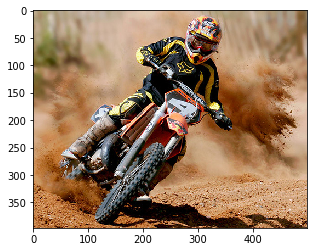

Greedy: dirt biker rides through dirt hill


In [105]:
#z+=1
pic = list(encoding_test.keys())[1]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [114]:
#ixtoword={}
#wordtoix={}
with open("./encoded_test_images.pkl", "rb") as encoded_pickle:
file = open("ixtoword.txt", 'w')
file.write(ixtoword.keys())
file.write(ixtoword.values())
file.close()

IndentationError: expected an indented block (<ipython-input-114-d0659714b5cf>, line 4)

dict_values(['startseq', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'way', 'endseq', 'girl', 'going', 'into', 'wooden', 'building', 'little', 'the', 'to', 'her', 'black', 'dog', 'and', 'spotted', 'are', 'fighting', 'tricolored', 'playing', 'with', 'each', 'other', 'on', 'road', 'white', 'brown', 'spots', 'staring', 'at', 'street', 'two', 'dogs', 'different', 'looking', 'pavement', 'moving', 'toward', 'covered', 'paint', 'sits', 'front', 'painted', 'rainbow', 'hands', 'bowl', 'sitting', 'large', 'small', 'grass', 'plays', 'it', 'there', 'pigtails', 'painting', 'young', 'outside', 'man', 'lays', 'bench', 'while', 'his', 'by', 'him', 'which', 'also', 'tied', 'sleeping', 'next', 'shirtless', 'lies', 'park', 'laying', 'holding', 'leash', 'ground', 'orange', 'hat', 'something', 'wears', 'glasses', 'wearing', 'beer', 'can', 'ears', 'rope', 'net', 'red', 'climbs', 'bridge', 'onto', 'ropes', 'playground', 'running', 'grassy', 'garden', 'surrounded', 'fe